### Library Import

In [14]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

sys.path.append("..")

from src.sanity import *

In [15]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [16]:
from src.load_datasets import load_air_polution_data

dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_data, freq="H")
)

print(f"dataframe shape {dataframe.shape}")

dataframe = dataframe.tail(515)

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (43800, 7)
dataframe shape (43800, 7)


,pollution,dewp,temp,press,wnd_spd,snow,rain
Date_Time,,,,,,,
2014-12-10 13:00:00,62.0,-17.0,5.0,1025.0,32.62,0.0,0.0
2014-12-10 14:00:00,45.0,-19.0,5.0,1026.0,43.80,0.0,0.0
2014-12-10 15:00:00,19.0,-19.0,5.0,1026.0,53.63,0.0,0.0
2014-12-10 16:00:00,21.0,-18.0,4.0,1027.0,61.68,0.0,0.0
2014-12-10 17:00:00,13.0,-18.0,2.0,1028.0,70.62,0.0,0.0


### test_train_split

train_xy and test_xy size: (500, 7), (15, 7)

y_train and x_train size (500,), (500, 6)
y_test  and x_test  size (15,),  (15, 6)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

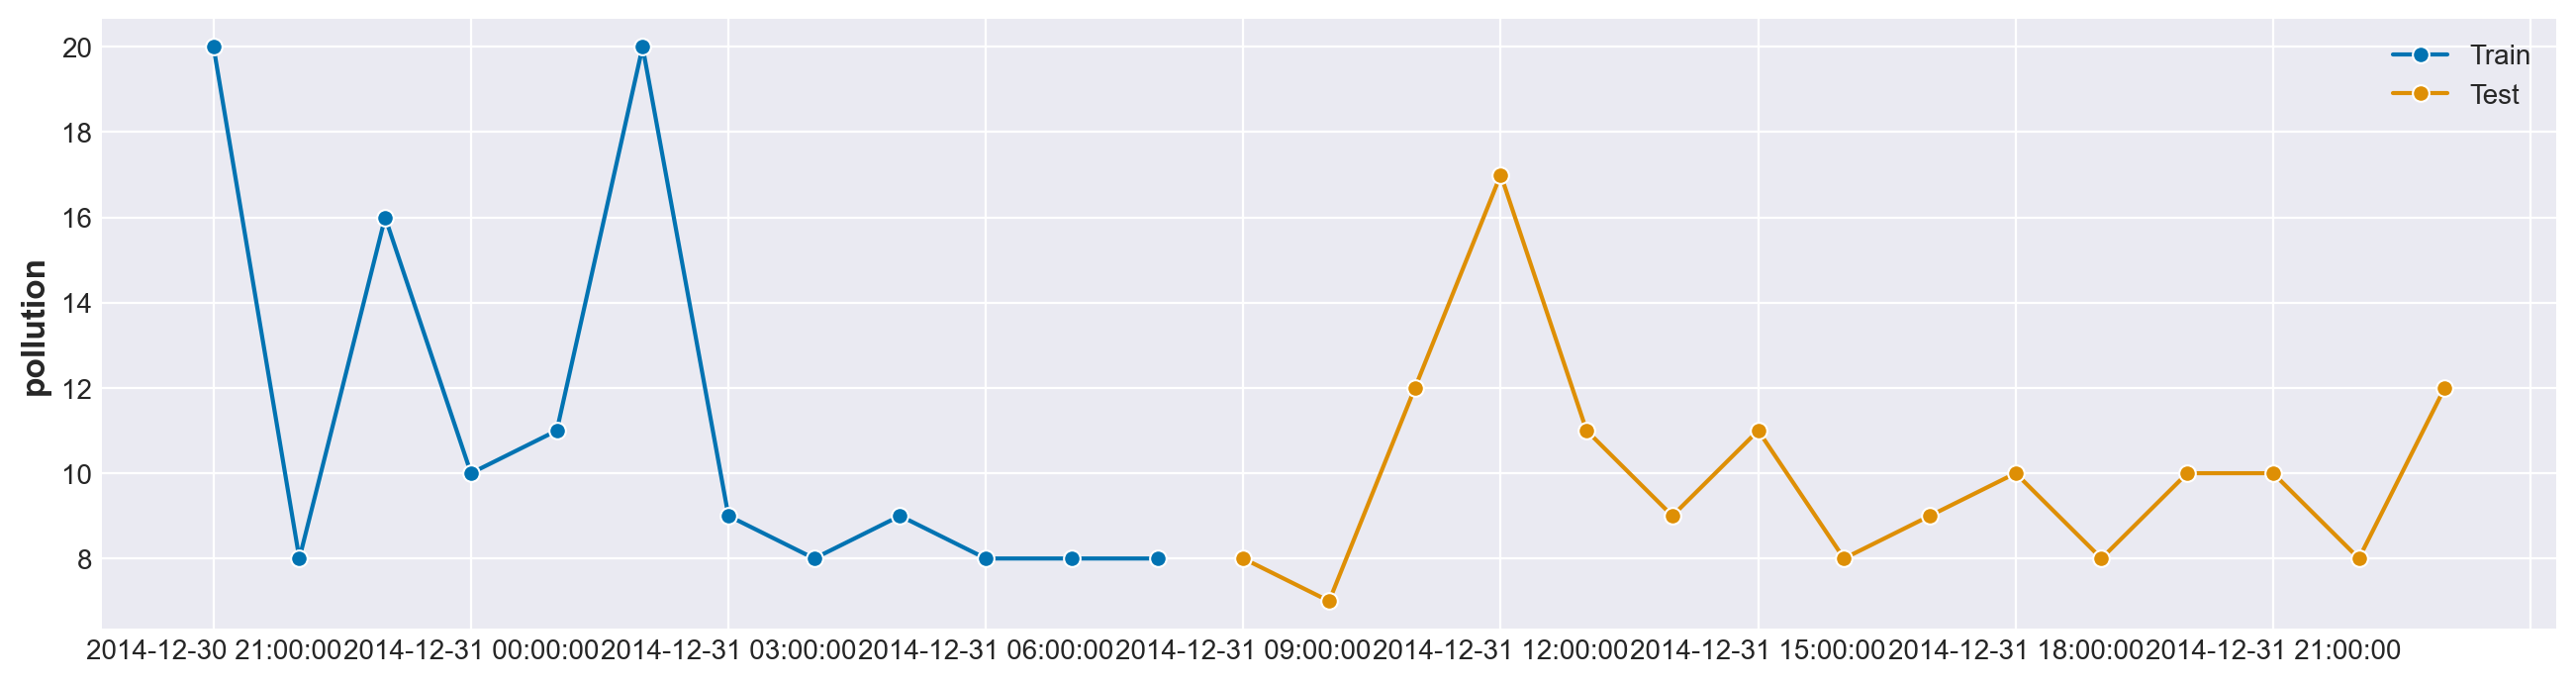

In [17]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "pollution"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(12), y_test, labels=["Train", "Test"])

In [18]:
import joblib

trained_model = joblib.load("./model_1.joblib")


model_n_features_in = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = trained_model.get_fitted_params()["forecaster__reducer__estimator__coef"]
model_intercept = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_fname_in {model_coeff}", end="\n\n")
print(f"model_fname_in {model_intercept}", end="\n\n")

model_n_features_in 16

model_fname_in ['pollution_lag_1' 'pollution_lag_2' 'pollution_lag_3' 'pollution_lag_4'
 'pollution_lag_5' 'pollution_lag_6' 'pollution_lag_7' 'pollution_lag_8'
 'pollution_lag_9' 'pollution_lag_10' 'dewp' 'temp' 'press' 'wnd_spd'
 'snow' 'rain']

model_fname_in [ 1.05913177e+00 -3.94606685e-02 -9.76884525e-02  4.65861437e-02
 -9.35489650e-02 -1.09772487e-02  5.44675471e-02 -4.78939493e-02
  1.52315404e-02  1.64099717e-02  2.15708076e+01 -8.20984470e+00
  3.92403850e+00 -4.89692636e+00  0.00000000e+00  0.00000000e+00]

model_fname_in -9.096488114810722



### Forecasting

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

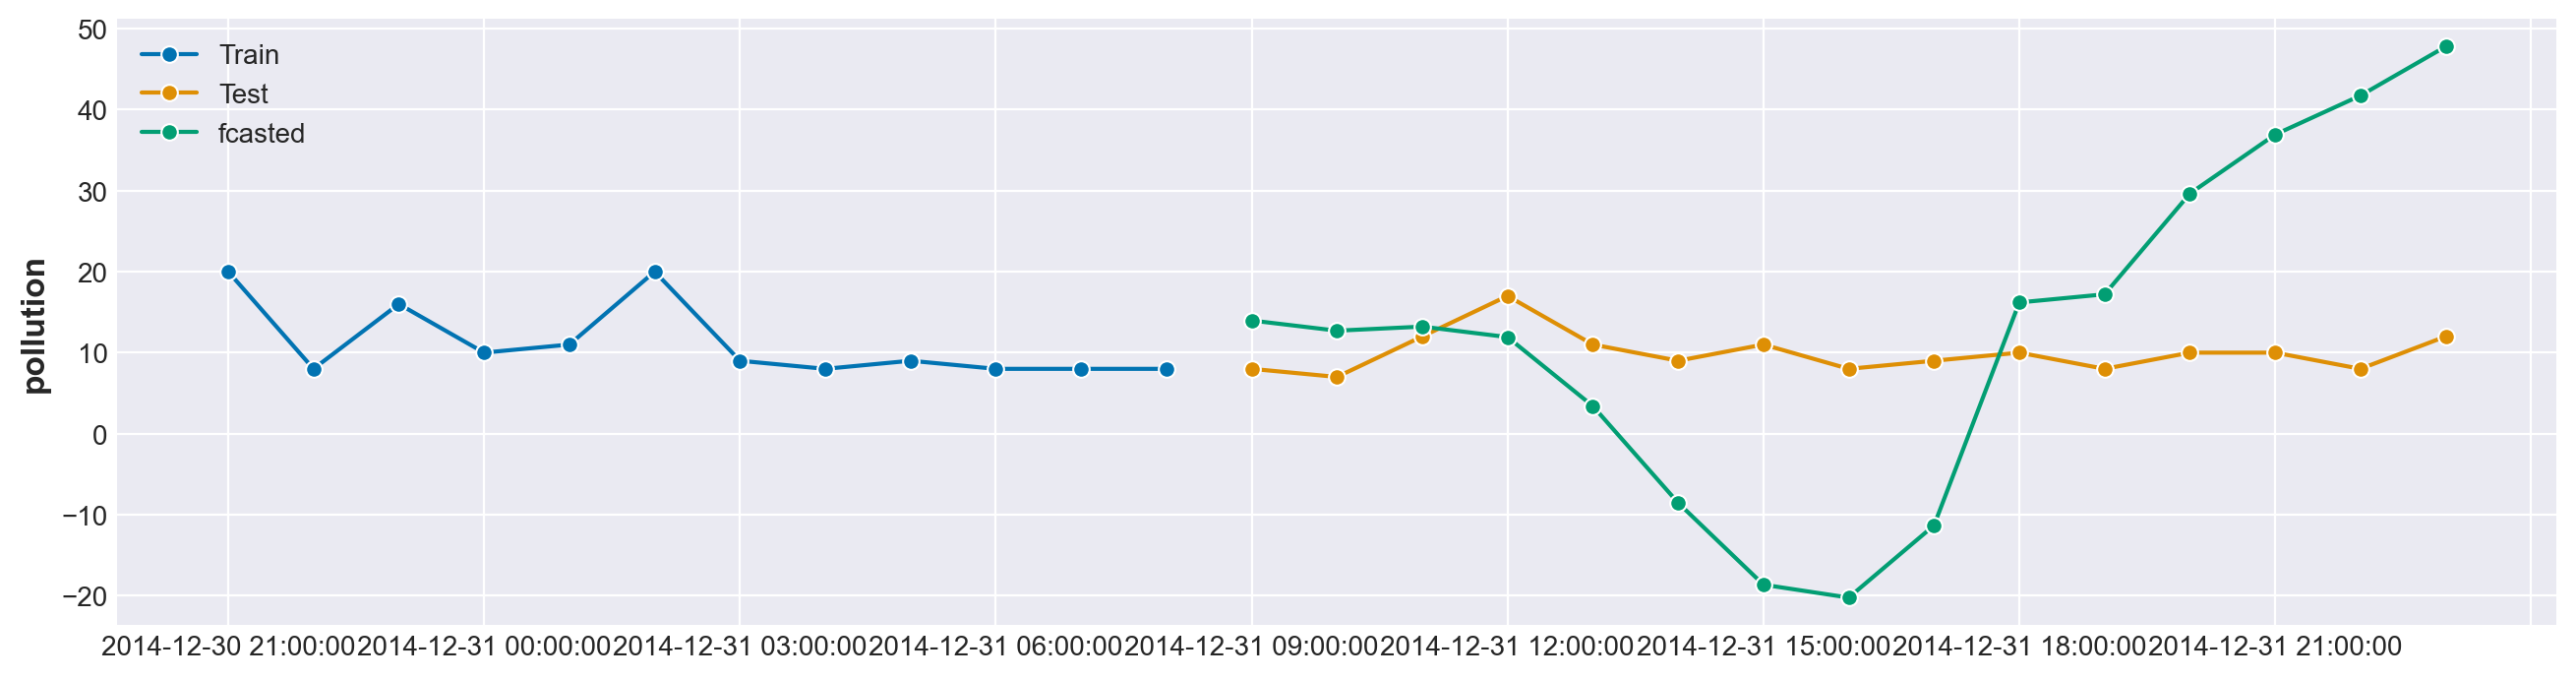

In [19]:
fh = np.arange(1, TEST_SIZE + 1)

y_fcasted = trained_model.predict(fh, X=x_test)

plot_series(y_train.tail(12), y_test, y_fcasted, labels=["Train", "Test", "fcasted"])

In [13]:
print(trained_model.cutoff)

DatetimeIndex(['2014-12-31 08:00:00'], dtype='datetime64[ns]', name='Date_Time', freq='H')


In [20]:
x_test.head()

,dewp,temp,press,wnd_spd,snow,rain
Date_Time,,,,,,
2014-12-31 09:00:00,-22.0,-3.0,1034.0,155.99,0.0,0.0
2014-12-31 10:00:00,-22.0,-2.0,1034.0,163.14,0.0,0.0
2014-12-31 11:00:00,-22.0,-2.0,1034.0,170.29,0.0,0.0
2014-12-31 12:00:00,-22.0,0.0,1033.0,177.44,0.0,0.0
2014-12-31 13:00:00,-27.0,0.0,1032.0,186.38,0.0,0.0


In [21]:
x_modified = x_test[["press", "wnd_spd", "snow", "rain", "dewp", "temp"]]
x_modified.head()

,press,wnd_spd,snow,rain,dewp,temp
Date_Time,,,,,,
2014-12-31 09:00:00,1034.0,155.99,0.0,0.0,-22.0,-3.0
2014-12-31 10:00:00,1034.0,163.14,0.0,0.0,-22.0,-2.0
2014-12-31 11:00:00,1034.0,170.29,0.0,0.0,-22.0,-2.0
2014-12-31 12:00:00,1033.0,177.44,0.0,0.0,-22.0,0.0
2014-12-31 13:00:00,1032.0,186.38,0.0,0.0,-27.0,0.0


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

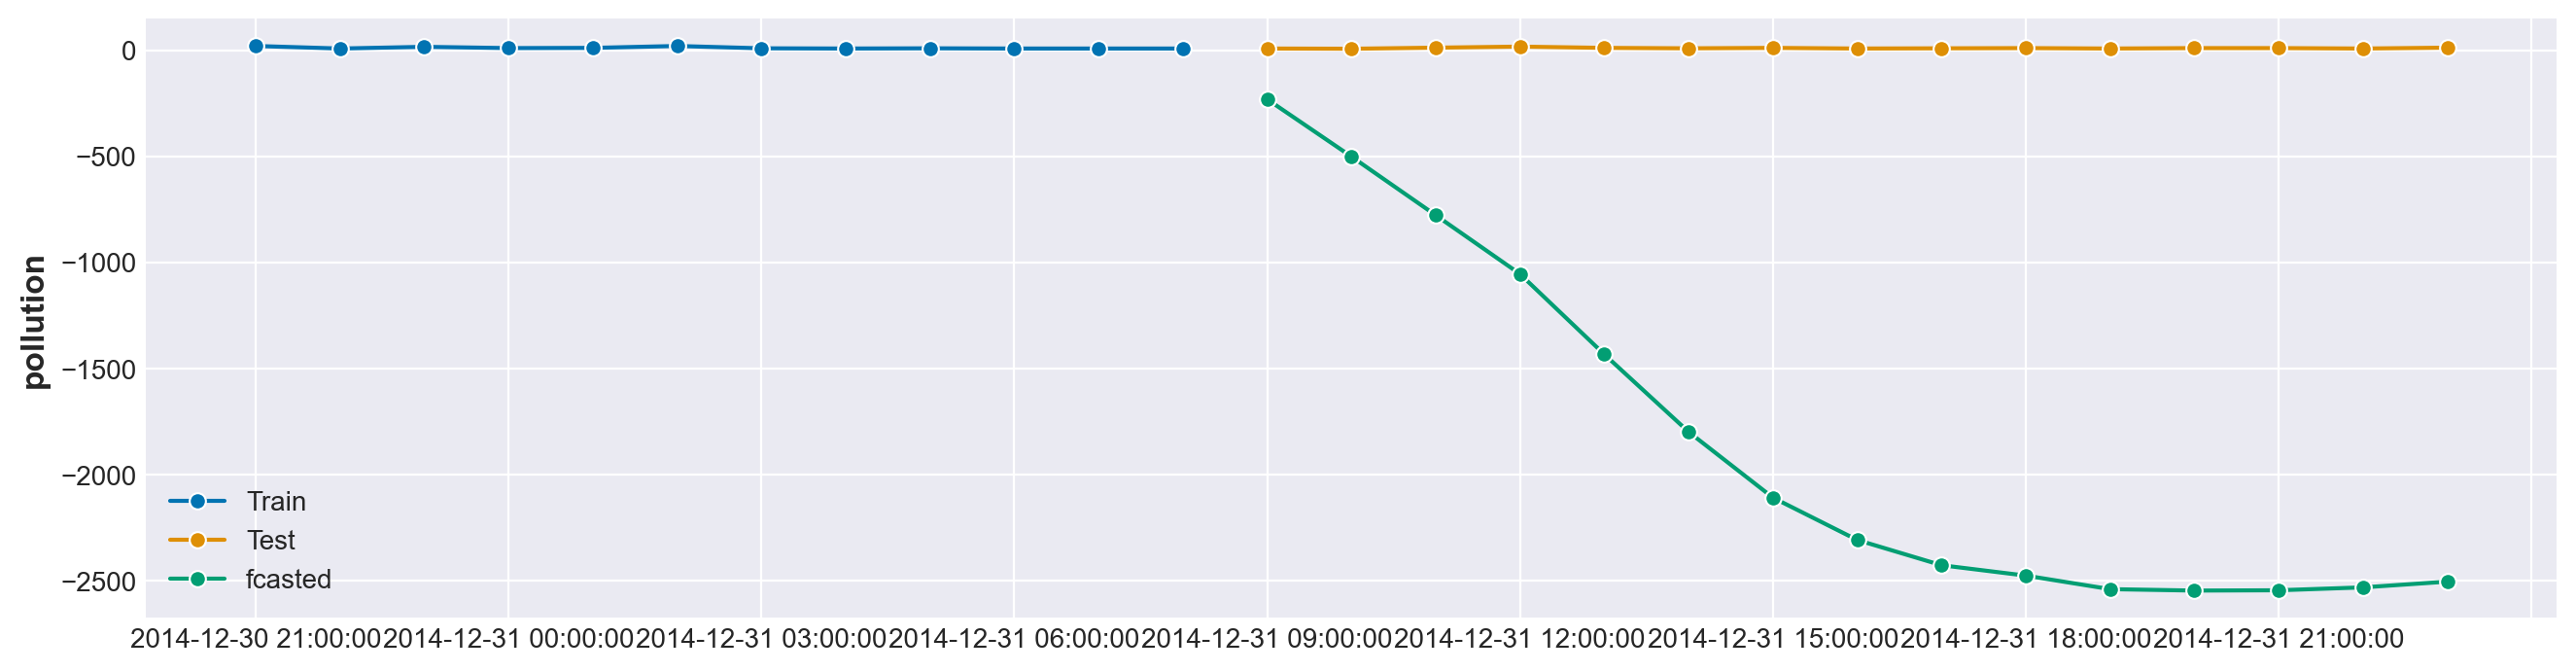

In [22]:
fh = np.arange(1, TEST_SIZE + 1)

y_fcasted = trained_model.predict(fh, X=x_modified)

plot_series(y_train.tail(12), y_test, y_fcasted, labels=["Train", "Test", "fcasted"])